### Установка нужных библиотек

In [ ]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
!wget -q -O requirements.txt https://raw.githubusercontent.com/Intelligent-Systems-Phystech/2022-Project-90/master/code/requirements.txt
!pip install -q -r requirements.txt

In [2]:
import pyEDM as edm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

In [24]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [25]:
!mkdir images

mkdir: невозможно создать каталог «images»: Файл существует


### Обработка данных, полученных с акселерометра и гироскопа

In [26]:
data = pd.read_json("./signals/dev_round_and_round.json", orient="records")

In [27]:
COLUMNS_TO_DELETE = ['version', 'device name', 'recording time', 
                     'platform', 'appVersion', 'device id', 
                     'sensors', 'sampleRateMs', 'time', 
                     'seconds_elapsed']

data.drop(columns=COLUMNS_TO_DELETE, inplace=True)
data.drop(data.tail(1).index, inplace=True)
# data['ms'] = data['seconds_elapsed'].apply(lambda sec: 1000 * (sec - data.seconds_elapsed[0]))
# data.drop(columns=['seconds_elapsed'], inplace=True)

In [28]:
acc_data = data.loc[data.sensor == 'Accelerometer']
gyr_data = data.loc[data.sensor == 'Gyroscope']

acc_data.drop(columns=['sensor'], inplace=True)

gyr_data.drop(columns=['sensor'], inplace=True)
gyr_data.reset_index(drop=True, inplace=True)

/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
devices_data = pd.concat([acc_data, gyr_data], axis=1)
devices_data.columns = ['acc_z', 'acc_y', 'acc_x', 'gyr_z', 'gyr_y', 'gyr_x']
devices_data.insert(0, "time", np.arange(1, devices_data.shape[0]+1))

### Обработка видео

In [276]:
video_data = pd.read_json("./encoded_video/vid_round_and_round.json", orient="records")

In [277]:
COLUMNS_TO_DELETE = ['image_id', 'category_id', 'score', 'box', 'idx']
video_data.drop(columns=COLUMNS_TO_DELETE, inplace=True)

In [278]:
KEYPOINTS_CNT = 68

for i in range(3*KEYPOINTS_CNT):
    if i % 3 == 0:
        col_name = f"x_{i//3}"
    elif i % 3 == 1:
        col_name = f"y_{i//3}"
    else:
        continue
        
    video_data[col_name] = video_data['keypoints'].apply(lambda keypoint: keypoint[i])

/tmp/ipykernel_7382/1987621593.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  video_data[col_name] = video_data['keypoints'].apply(lambda keypoint: keypoint[i])


In [279]:
video_data.drop(columns=['keypoints'], inplace=True)

### Выравнивание рядов

In [280]:
devices_ts_size = devices_data.shape[0]
video_ts_size = video_data.shape[0]

expansion_coef = math.ceil(devices_ts_size / video_ts_size)
excess_repeat_cnt = expansion_coef * video_ts_size - devices_ts_size
indices_to_delete = np.linspace(0, expansion_coef*video_ts_size, excess_repeat_cnt, 
                                dtype=int)
indices_to_delete[-1] = expansion_coef*video_ts_size - 1

expanded_video_data = pd.DataFrame(np.repeat(video_data.values, 
                                             expansion_coef, 
                                             axis=0), 
                                   columns=video_data.columns)
expanded_video_data.drop(index=indices_to_delete, inplace=True)
expanded_video_data.reset_index(drop=True, inplace=True)

### Отбор признаков с помощью CCM

In [281]:
# Объединение полученных ранее данных в одну таблицу
big_data = pd.concat([devices_data, expanded_video_data], axis=1)
big_data.head()

,time,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x,x_0,y_0,x_1,...,x_63,y_63,x_64,y_64,x_65,y_65,x_66,y_66,x_67,y_67
0,1,0.370580,-0.333001,-0.495055,0.113037,-0.014145,-0.106216,345.666656,117.592667,367.427948,...,257.853729,369.177612,206.592667,409.274017,237.972290,398.749695,251.755814,391.596771,262.010071,382.227203
1,2,0.416435,-0.296030,-0.354957,0.123703,-0.021606,-0.044434,345.666656,117.592667,367.427948,...,257.853729,369.177612,206.592667,409.274017,237.972290,398.749695,251.755814,391.596771,262.010071,382.227203
2,3,0.270992,-0.177669,-0.164412,0.117310,-0.033325,0.017349,345.666656,117.592667,367.427948,...,257.853729,369.177612,206.592667,409.274017,237.972290,398.749695,251.755814,391.596771,262.010071,382.227203
3,4,0.091093,-0.005039,-0.023911,0.088547,-0.056763,0.053574,345.687714,117.775414,367.416534,...,258.168030,368.743744,209.326233,408.544983,241.094421,397.535004,253.388840,390.331818,262.464172,381.404114
4,5,0.004578,0.130435,0.109131,0.043808,-0.065277,0.058899,345.687714,117.775414,367.416534,...,258.168030,368.743744,209.326233,408.544983,241.094421,397.535004,253.388840,390.331818,262.464172,381.404114


In [158]:
libsize = "2000"
corr_mat = np.zeros((video_data.shape[1], devices_data.shape[1]-1))

for i, col in enumerate(video_data.columns):
    for j, target in enumerate(devices_data.columns[1:]):
        # output: LibSize, col:target, target:col
        output = edm.CCM(dataFrame=big_data, E=4, columns=col, target=target,
                         libSizes=libsize, random=False)
        corr_mat[i, j] = output.values[0, 1]
        
corr_mat = corr_mat.T
# np.savetxt("corr_mat.txt", corr_mat)

In [282]:
# Отбор признаков исходя из коэфф.корреляций, полученных CCM
extra_feat_cnt = 10
extra_feat_inds = corr_mat.argsort(axis=1)[:, :extra_feat_cnt]

### Предскаазние временного ряда

In [298]:
# Предсказание моделей
for i, col in enumerate(devices_data.columns[1:]):
    edm.SMap(dataFrame=big_data, 
             lib="1 2000", 
             pred="2001 3277", 
             predictFile=f"preds/common_{col}_pred.csv",
             embedded=False, 
             E=4, 
             target=col, 
             columns=[col], 
             theta=2, 
             showPlot=False);
    
    edm.SMap(dataFrame=big_data, 
             lib="1 2000", 
             pred="2001 3277", 
             predictFile=f"preds/updated_{col}_pred.csv",
             embedded=True, 
             target=col, 
             columns=list(video_data.columns[extra_feat_inds[i]])+[col], 
             theta=2, 
             showPlot=False);

### Построение графиков

In [38]:
predictions = []

for col in devices_data.columns[1:]:
    common_df = pd.read_csv(f"preds/common_{col}_pred.csv", usecols=['Observations', 'Predictions'])
    extra_df = pd.read_csv(f"preds/updated_{col}_pred.csv", usecols=['Predictions'])
    
    predictions.append(pd.concat([common_df, extra_df], axis=1))
    predictions[-1].columns = ['true_values', 'common_pred', 'updated_pred']
    predictions[-1].dropna(inplace=True)

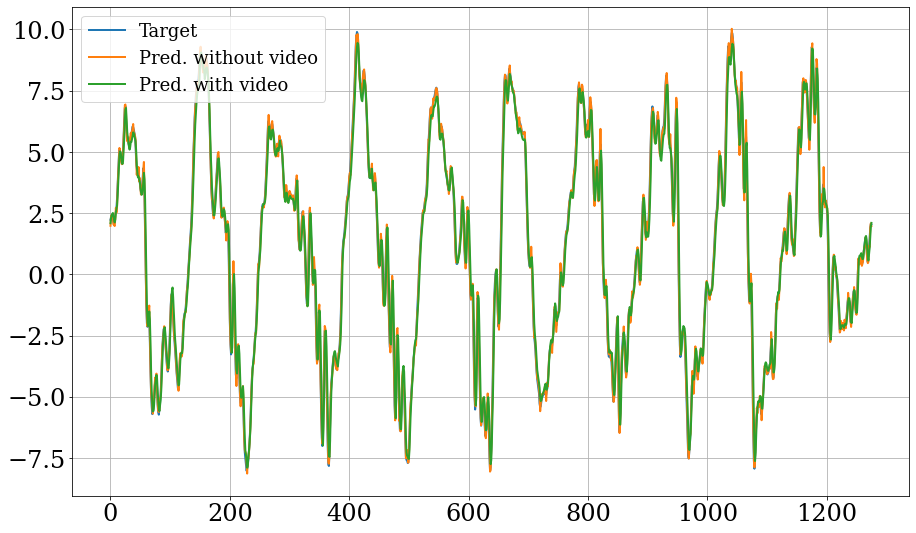

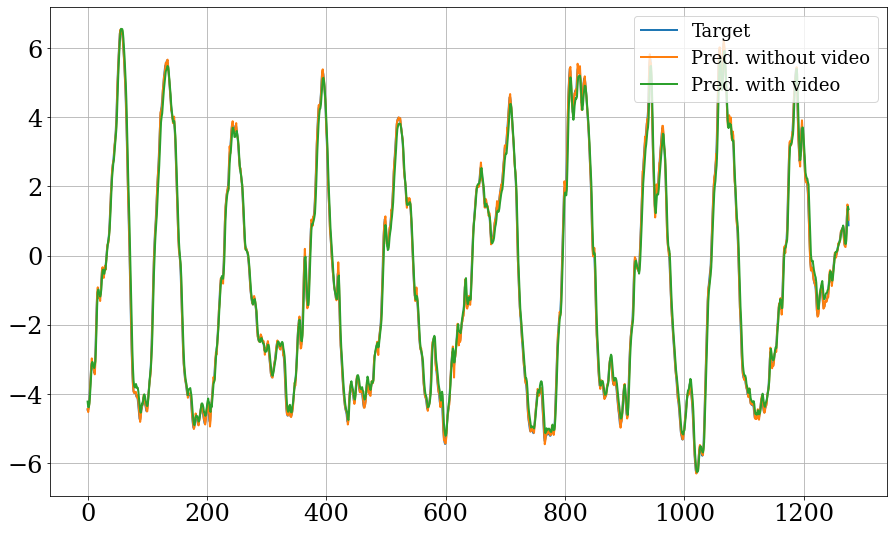

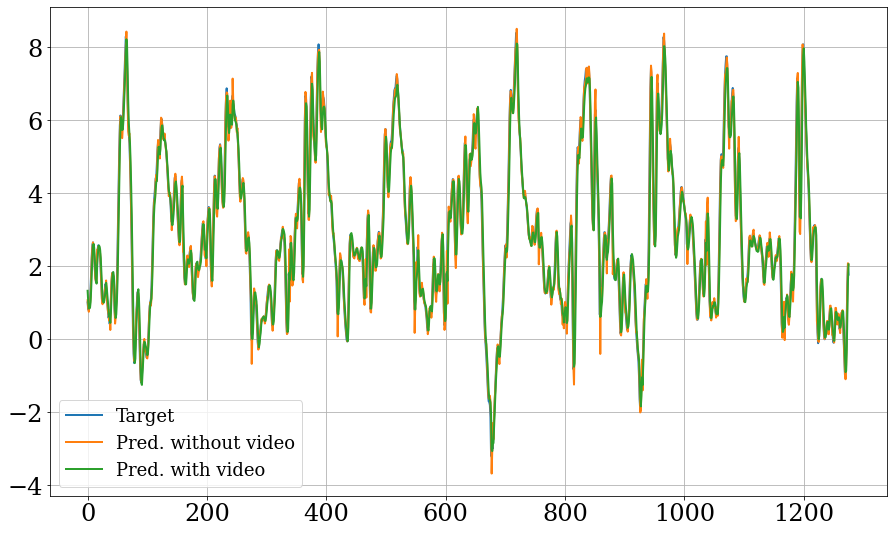

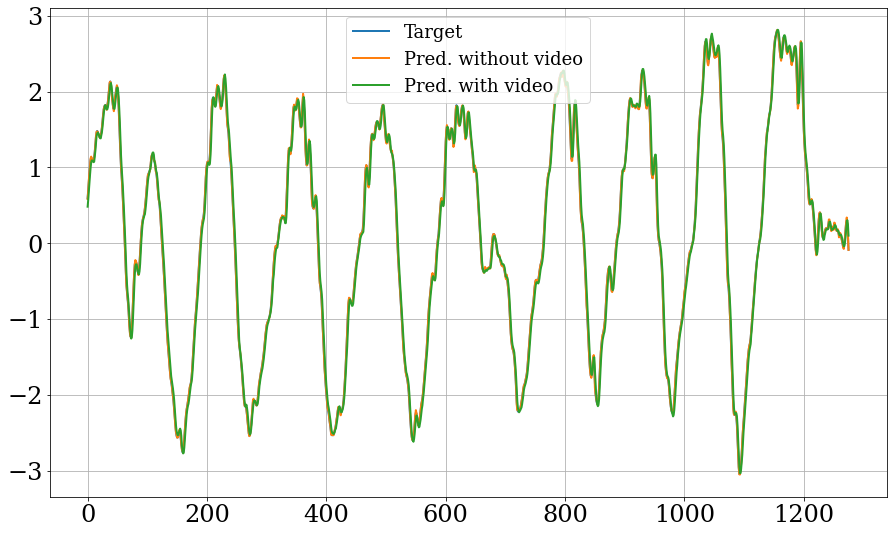

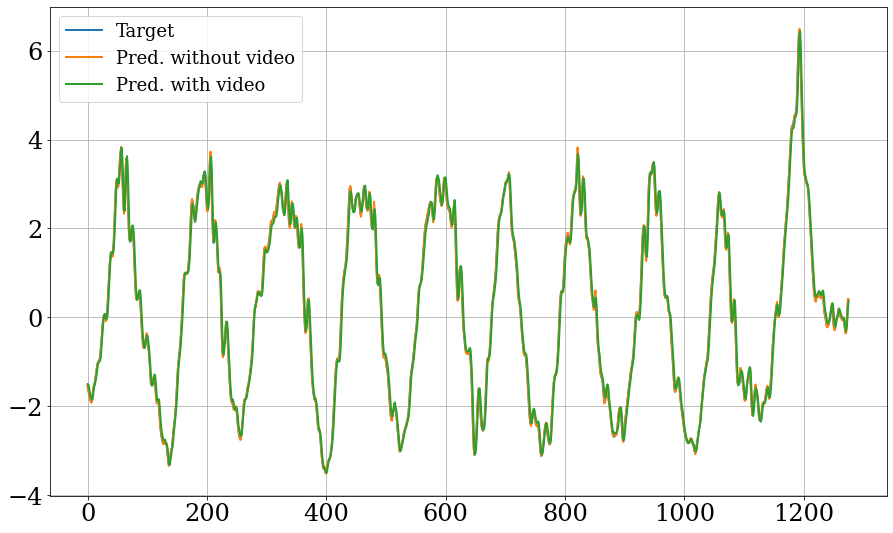

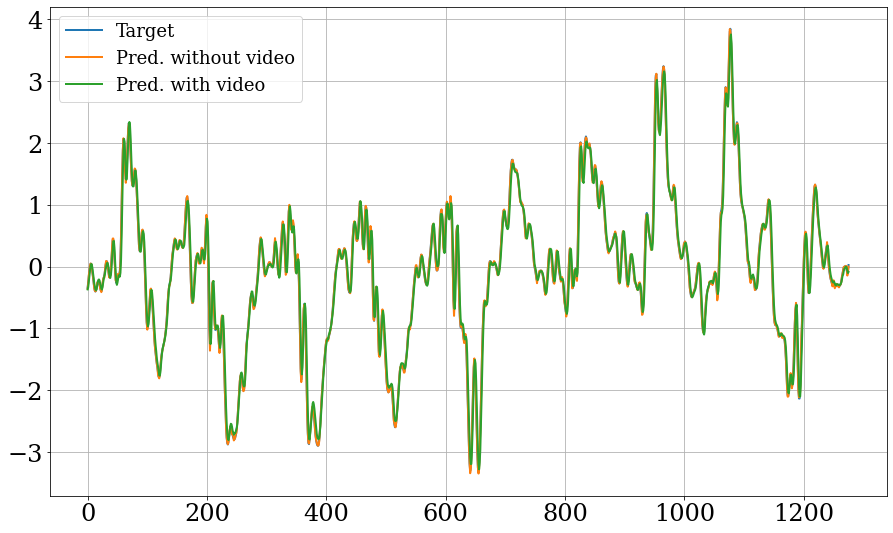

In [39]:
for i, col in enumerate(devices_data.columns[1:]):
    values = predictions[i].values

    plt.figure(figsize=(15, 9))
    plt.plot(values[:, 0], label="Target")
    plt.plot(values[:, 1], label="Pred. without video")
    plt.plot(values[:, 2], label="Pred. with video")

    plt.grid(True)
    plt.legend()
    plt.savefig(f"images/{col}_pred.png");